In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(20, grid_bounds=[(0, 1), (0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel()
model.condition(train_x, train_y)

KissGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [4]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.numpy()
    
    test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')
    
    return f

In [5]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(60):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

/home/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/60 - Loss: 1726.916
Iter 2/60 - Loss: 1643.580
Iter 3/60 - Loss: 1568.952
Iter 4/60 - Loss: 1494.047
Iter 5/60 - Loss: 1414.487
Iter 6/60 - Loss: 1330.472
Iter 7/60 - Loss: 1240.694
Iter 8/60 - Loss: 1145.976
Iter 9/60 - Loss: 1037.426
Iter 10/60 - Loss: 918.939
Iter 11/60 - Loss: 799.713
Iter 12/60 - Loss: 705.306
Iter 13/60 - Loss: 604.281
Iter 14/60 - Loss: 512.899
Iter 15/60 - Loss: 418.265
Iter 16/60 - Loss: 342.382
Iter 17/60 - Loss: 257.833
Iter 18/60 - Loss: 163.529
Iter 19/60 - Loss: 87.576
Iter 20/60 - Loss: 20.487
Iter 21/60 - Loss: -60.796
Iter 22/60 - Loss: -159.812
Iter 23/60 - Loss: -223.631
Iter 24/60 - Loss: -303.061
Iter 25/60 - Loss: -380.917
Iter 26/60 - Loss: -447.300
Iter 27/60 - Loss: -533.480
Iter 28/60 - Loss: -583.505
Iter 29/60 - Loss: -666.347
Iter 30/60 - Loss: -729.733
Iter 31/60 - Loss: -777.295
Iter 32/60 - Loss: -852.723
Iter 33/60 - Loss: -911.544
Iter 34/60 - Loss: -965.126
Iter 35/60 - Loss: -991.594
Iter 36/60 - Loss: -993.757
Iter 37/60 - Lo

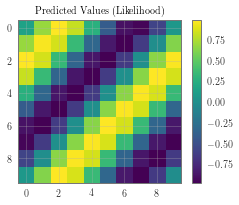

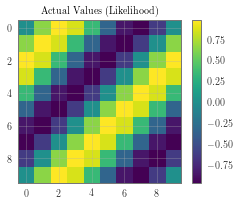

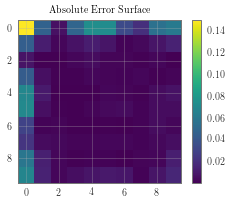

In [6]:
f = plot_model_and_predictions(model)